In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 7)

coffee = pd.read_csv('data/coffee.csv', index_col=0)

true = pd.read_csv('data/missing_true.csv')
unif = pd.read_csv('data/missing_unif.csv')
depd = pd.read_csv('data/missing_depd.csv')
mi_corr = pd.read_csv('data/mi_corr.csv')

def plot_distributions(**kwargs):
    '''plot two series/'''
    L = [v.assign(missing=k) for (k, v) in kwargs.items()]
    title = 'distribution of value'
    G = pd.concat(L).groupby('missing')['value']
    return G.plot(kind='kde', legend=True, title=title);
    return G.plot(kind='hist', legend=True, title=title, bins=15, density=True, alpha=0.5)

# Probabilistic Imputation
---

One of the problems with single-valued imputation is that the variance of the imputed data decreases, impacting the quality of inference and prediction with the dataset. A simple approach to this problem involves imputing the missing values *probabilistically* from a distribution of reasonable values.

## Imputation with a Distribution
The easiest approach to probabilistic imputation draws from the empirical distribution of the attribute being imputed.

**Example:** Probabilistic imputation of a categorical attribute overcomes the shortfalls of single-valued imputation with the mode. Imputing the 'label' column in the toy dataset from the previous section:

In [3]:
labels = unif['label']

# Draw from the empirical distribution and fill in missing values:
distr = labels.dropna().sample(n=unif.shape[0], replace=True).reset_index(drop=True)
probabilistic_imputation_cat = labels.fillna(distr)

In [4]:
# Fill in missing data with the mode (single value)
mode = labels.mode().squeeze()
single_imputation_cat = labels.fillna(mode)

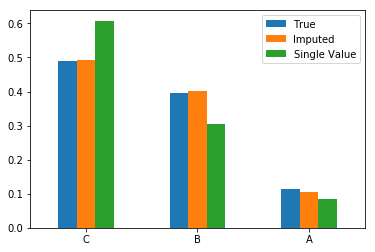

In [5]:
pd.concat([
    true['label'].value_counts(normalize=True).rename('True'),
    probabilistic_imputation_cat.value_counts(normalize=True).rename('Imputed'),
    single_imputation_cat.value_counts(normalize=True).rename('Single Value')
], axis=1).plot(kind='bar', rot=0);

In order to probabilistically impute a quantitative attribute, one needs to compute a quantitative distribution from which to draw. This can be handled in two ways:
1. If the observed values are numerous, the distribution can be treated as categorical and sampled from directly.
2. If values outside the observed dataset need to be considered in the imputation, one needs to estimate the quantitative distribution through either binning or kernel density estimates, and draw from those distributions.

**Example:** Imputing the value column considering the attribute as categorical results in an imputed column quite similar to the true distribution. Note that the 'bump' in the distribution of the single-valued imputation is due to adding all the missing mass to the mean of the distribution. The probabilistic imputation avoids this.

In [6]:
values = unif['value']

imputed = (
    values
    .fillna(
        values.dropna().sample(n=unif.shape[0], replace=True).reset_index(drop=True)
    )
)

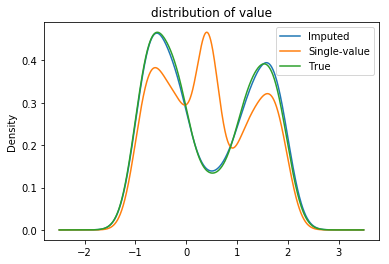

In [7]:
plot_distributions(**{
    'True': true, 
    'Imputed': unif.assign(value=imputed), 
    'Single-value': unif.assign(value=values.fillna(unif.value.mean()))}
);

**Example:** The above examples imputed an attribute using a single column, yielding an unbiased estimate of an MCAR distribution. However, if the attribute under investigation is missing dependent on another column, the probabilistic imputation must draw from a *conditional* distribution in much the same way group-wise single-valued imputation did.

## Multiple Imputation

While probabilistic imputation removes the issue of decreased variance when filling in missing values, it necessarily suffers from uncertainty: if the imputation is repeated, a different distribution is created. When performing a statistical analysis, this difference in the imputation process may then yield a difference end result. Multiple imputation, first developed by Donald Rubin in 1977, is the process of quantifying this uncertainty from the imputation in terms of a *distribution* of analyses.

Multiple imputation involves repeating the following procedure:
1. Computing a probabilistic imputation,
1. Analyzing the imputed dataset and computing a test-statistic

Repeating this procedure results in a distribution of test-statistics. The variance of these statistics explains the dependency of the result on the imputation procedure.

**Example:** Suppose the dataset `mi_corr` has two quantitative attributes that are unconditionally missing at random (MCAR). Computing the distribution of correlation coefficients under the framework of multiple imputation proceeds as follows:

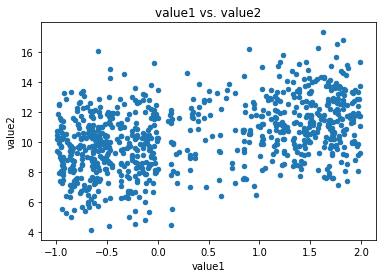

In [8]:
mi_corr.plot(kind='scatter', x='value1', y='value2', title='value1 vs. value2');

Create a function to unconditionally impute from a distribution:

In [9]:
def impute_from_distrib(col):
    '''unconditionally impute from a distribution.'''
    imputed = col.dropna().sample(n=len(col), replace=True).reset_index(drop=True)
    return col.fillna(imputed)

Multiple imputation then proceeds by repeatedly:
1. imputing the columns 'value1' and 'value2' with `impute_from_distrib` and
1. computing the correlation coefficient of the imputed columns

In [10]:
from scipy.stats import linregress

Rs = []
for _ in range(1000):
    
    r = linregress(mi_corr.apply(impute_from_distrib)).rvalue
    Rs.append(r)

The resulting correlation coefficients, from the multiple imputations, then provide a distribution of results:

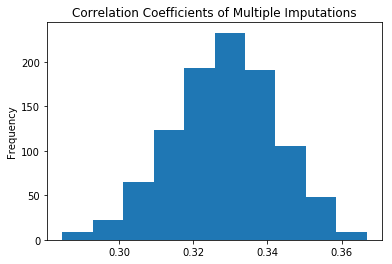

In [11]:
pd.Series(Rs).plot(kind='hist', title='Correlation Coefficients of Multiple Imputations');

The most common value for the correlation coefficient is $0.33$, with values ranging $\pm 0.04$.